# QuantLET example: Infinite Spreadsheets

http://quantlet.net

This example shows the use of QuantLET reactives for on-demand realtime computations. Reactives can be connected to streams to consume or generate signals.

This example shows the calculation of portfolio values based on changes of prices or quantities of assets, applied to stocks. 

This is a very simple and unrealistic example of quantlet, an on-going research work. 

(c) 2014 Jorge M. Faleiro Jr

## Initialization

First things first, import what we will need from QuantLET and set configuration of underlying libraries

In [1]:
from quantlet.reactive import R, describe, sum_all
from quantlet.streams import QLet, figsize

interactive mode
dataset registration...
dataset fifo
imported <module 'quantlet.ds.fifo' from 'quantlet/ds/fifo.pyc'>, scheme=fifo
dataset mpubsub
imported <module 'quantlet.ds.mpubsub' from 'quantlet/ds/mpubsub.pyc'>, scheme=mpubsub
dataset plot
cannot load plot
dataset pubsub
cannot load pubsub
dataset rw
imported <module 'quantlet.ds.rw' from 'quantlet/ds/rw.pyc'>, scheme=rw
dataset sendreceive
cannot load sendreceive
dataset std
imported <module 'quantlet.ds.std' from 'quantlet/ds/std.pyc'>, scheme=stdout


In [2]:
from __future__ import print_function
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Simple Reactive Model

Let's define the reactive model: first the primitives, STOCKS and PRICE...

In [3]:
STOCKS = R(0,'STOCKS')
PRICE = R(0.0, 'PRICE')

... and the definition of a reactive POSITION, given by STOCKS*PRICE

In [4]:
POSITION = STOCKS * PRICE

That's it, done. How does the reactive model we just created look like?

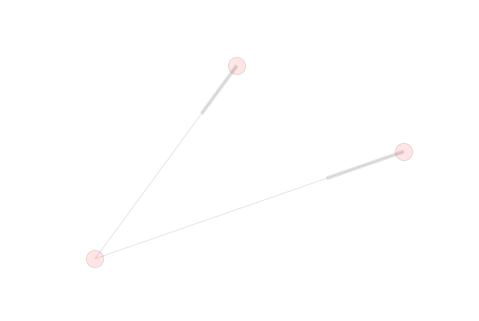

In [5]:
describe(POSITION)

Pretty clear... we have a reactive POSITION (given by STOCKS*PRICE) and a dependency from POSITION to reactive primitives STOCKS and PRICE, i.e. whenever PRICE or STOCKS change, so does POSITION.

Let's play with this model and do something useful with it. 

Just for the sake of ilustration (and debugging), we will add a listener to reactive POSITION, printing our overall position value whenever it changes

In [6]:
POSITION.add_listener(lambda x,y: print('position changed: %s' % x) )

We can change either STOCKS or PRICE...

In [7]:
PRICE.val = 1.0
STOCKS.val = 10
PRICE.val = 0.0
STOCKS.val = 0

position changed: [STOCKS*PRICE](0.0)
position changed: [STOCKS*PRICE](10.0)
position changed: [STOCKS*PRICE](0.0)
position changed: [STOCKS*PRICE](0.0)


...our position changes, and our listener reacts to the change showing the latest position value

Now, we will show how to bind this reactive model to a quantlet stream. 

We will do that by a QLet called 'tick' we create here inline: 

In [8]:
@QLet
def tick(iterator):
    for i in iterator:
        if 'q' in i:
            STOCKS.val = i['q']
        if 'p' in i:
            PRICE.val = i['p']

We can now define a sequence of quantity and price changes (given for q quantity and p price) and stream it through 'tick' we just created, and watch the model tick through each change, we use the usual synchronous stream '>>' for that:

In [9]:
( \
 dict(q=10,p=9.97), \
 dict(p=9.12), \
 dict(p=8.00), \
 dict(q=9), \
) \
>> tick

position changed: [STOCKS*PRICE](0.0)
position changed: [STOCKS*PRICE](99.7)
position changed: [STOCKS*PRICE](91.2)
position changed: [STOCKS*PRICE](80.0)
position changed: [STOCKS*PRICE](72.0)


That's it for a simple model.

## A More Elaborated Reactive Model

Now, a bit more sophisticated example showing a model of objects Position and Portfolio.

In this model a Portfolio has a number of Positions associated to it, as well as a reactive PORTFOLIO, guaranteed to always hold the sum of all VALUE reactives across all Positions 

Each Position has a symbol (a string), a quantity, a price (reactive primitives QUANTITY and PRICE) and a value (reactive given by QUANTITY * PRICE)

In [10]:
class Position:
    def __init__(self, symbol):
        self.QUANTITY = R(0, '%s[QUANTITY]' % symbol)
        self.PRICE = R(0.0, '%s[PRICE]' % symbol)
        self.VALUE = self.QUANTITY * self.PRICE
        self.VALUE.label = symbol
        
class Portfolio:
    def __init__(self, *args):
        self.positions = dict((k.VALUE.label,k) for k in args)
        self.PORTFOLIO = sum_all([x.VALUE for x in args])

Structuring a portfolio is straighforward. In this case, we create a portfolio and 3 positions of GOOG, IBM ans MS.

In [11]:
IBM = Position('IBM')
MS = Position('MS')
GOOG = Position('GOOG')

portfolio = Portfolio(IBM, MS, GOOG)
portfolio.PORTFOLIO.label = 'portfolio'

And here's how the graph for this model looks like. Since this model has a bit more nodes, we will first increase the size of the figure to be displayed.

In [12]:
figsize(15.0, 12.0)

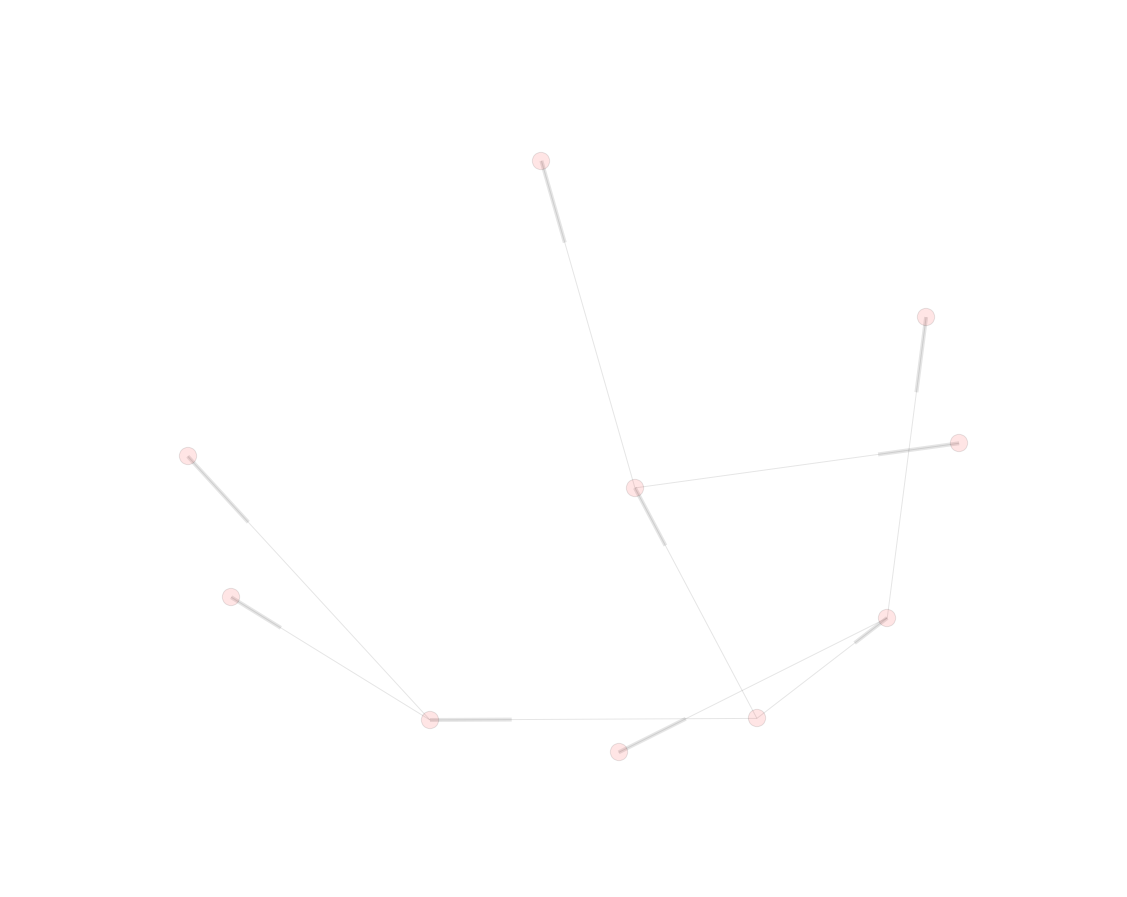

In [13]:
describe(portfolio.PORTFOLIO)

Same as before, let's add a listener to portfolio, for illustration and debugging purposes only...

In [14]:
portfolio.PORTFOLIO.add_listener(lambda x,y: print("portfolio changed: %s" % x) )

...and define a QLet to feed data in our model...

In [15]:
@QLet
def my_positions(iterator):
    for i in iterator:
        position = portfolio.positions[i['s']]
        if 'q' in i:
            position.QUANTITY.val = i['q']
        if 'p' in i:
            position.PRICE.val = i['p']

The same way as before, we can define some test data and flow through our model. Our listener will show modifications to the portfolio.

In [16]:
test_data = ( \
dict(s='GOOG', q=10, p=9.97),
dict(s='IBM', q=9, p=8.88),
dict(s='MS', p=9.12),
dict(s='MS', q=1, p=8.00),
dict(s='MS', q=9) \
)

test_data >> my_positions

portfolio changed: portfolio(0.0)
portfolio changed: portfolio(99.7)
portfolio changed: portfolio(99.7)
portfolio changed: portfolio(179.62)
portfolio changed: portfolio(179.62)
portfolio changed: portfolio(188.74)
portfolio changed: portfolio(187.62)
portfolio changed: portfolio(251.62)


We can also add listeners to any reactives, for example we can add listeners for every position in the portfolio:

In [17]:
for position in portfolio.positions.values():
    position.VALUE.add_listener(lambda x,y: print("position changed: %s" % x))

# and flow the same test data through our qlet:
test_data >> my_positions

portfolio changed: portfolio(251.62)
position changed: GOOG(99.7)
portfolio changed: portfolio(251.62)
position changed: GOOG(99.7)
portfolio changed: portfolio(251.62)
position changed: IBM(79.92)
portfolio changed: portfolio(251.62)
position changed: IBM(79.92)
portfolio changed: portfolio(261.7)
position changed: MS(82.08)
portfolio changed: portfolio(188.74)
position changed: MS(9.12)
portfolio changed: portfolio(187.62)
position changed: MS(8.0)
portfolio changed: portfolio(251.62)
position changed: MS(72.0)


## Additional Features

That's it. As a final reminder, reactives can be also bound to regular, more elaborate, QuantLET streams. For example...

## fixed quantities for each position
GOOG.QUANTITY.val = 10
IBM.QUANTITY.val = 15
MS.QUANTITY.val = 12

## each price to follow a different random walk, where s0=price at t0; mu=drift; sigma=volatility
random_walk(so=10.0, mu=0.1, sigma=0.25) >> GOOG.PRICE.val
random_walk(so=1.1, mu=-0.2, sigma=0.01) >> IBM.PRICE.val
random_walk(so=1.3, mu=-0.3, sigma=0.02) >> MS.PRICE.val

portfolio.PORTFOLIO >> plot

...will show a plot of changes of the portfolio value over time